<a href="https://colab.research.google.com/github/jeremysb1/enbpi_ts/blob/main/EnbPI_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble batch PIs (EnbPIs)

EnbPI is currently one of the most popular implementations of conformal prediction for time series forecasting. It has been implemented in popular open source conformal prediction libraries such as MAPIE, Amazon Fortuna, and PUNCC.

The problem this project is solving requires forecasting bike sharing demand expressed in the count of rented bikes.

In [ ]:
pip install aws-fortuna


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor

In [ ]:
pip install --upgrade git+https://github.com/google/flax.git

In [4]:
from fortuna.conformal import EnbPI
from fortuna.metric.regression import prediction_interval_coverage_probability

In [5]:
from sklearn.datasets import fetch_openml
bike_sharing = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas")

In [6]:
df = bike_sharing.frame
df.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0,16
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0,40
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0,32
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0,13
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0,1


In [7]:
df.shape

(17379, 13)

In [8]:
df.groupby(["weekday", "hour"])["count"].mean()

weekday  hour
0        0        93.990385
         1        77.432692
         2        61.627451
         3        31.144231
         4         9.362745
                    ...    
6        19      239.932692
         20      180.865385
         21      156.000000
         22      139.663462
         23      115.855769
Name: count, Length: 168, dtype: float64

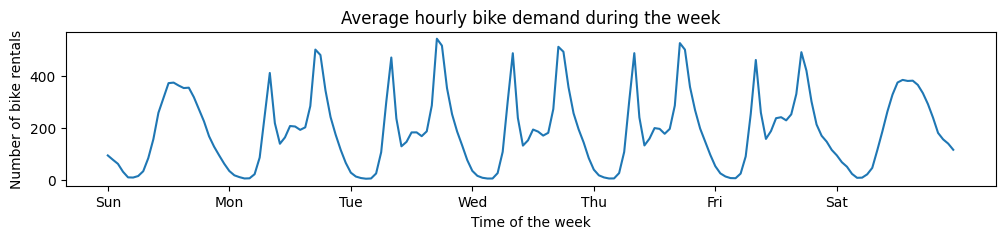

In [12]:
fig, ax = plt.subplots(figsize=(12, 2))
average_week_demand = df.groupby(["weekday", "hour"])["count"].mean()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)

In [13]:
df = df.sample(500)
y = df["count"] / df["count"].max()
X = df.drop("count", axis = "columns")
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)

## Data Bootstrapping

EnbPI requires bootstrapping the data, i.e. sampling with replacement random subsets of the time series and training a model for each of these samples.

In [16]:
class DataFrameBootstrapper:
    def __init__(self, n_samples: int):
        self.n_samples = n_samples

    def __call__(
        self, X: np.ndarray, y: np.ndarray
    ) -> tuple[np.ndarray, list[tuple[np.ndarray, np.ndarray]]]:
        indices = np.random.choice(y.shape[0], size=(self.n_samples, y.shape[0]))
        return indices, [(X.iloc[idx], y.iloc[idx]) for idx in indices]